In [1]:
from _global_vars import *
import seaborn as sns
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

22/11/22 22:14:45 WARN Utils: Your hostname, LAPTOP-VAB0S7AL resolves to a loopback address: 127.0.1.1; using 172.31.199.143 instead (on interface eth0)
22/11/22 22:14:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/11/22 22:14:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
# read in data
sdf_filtered = spark.read.parquet('../data/curated/yt2019_cleaned.parquet')
print(sdf_filtered.count())
#sdf.show(1, vertical=True, truncate=100)

2541382


### Taking a look at fare_per_minute (fpm)

In [3]:
sdf_filtered.describe('fare_per_minute').show()

+-------+-------------------+
|summary|    fare_per_minute|
+-------+-------------------+
|  count|            2541382|
|   mean| 0.9513091002091258|
| stddev|0.24509683013047973|
|    min|0.07122507122507123|
|    max|   4.37956204379562|
+-------+-------------------+



In [4]:
avg_fpm_weekday = sdf_filtered.groupBy('PU_dayofweek') \
            .agg(
                { 'fare_per_minute' : 'mean', }
                ) \
            .toPandas()

<AxesSubplot:xlabel='PU_dayofweek', ylabel='avg(fare_per_minute)'>

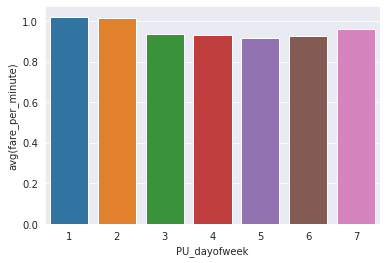

In [5]:
sns.barplot(x=avg_fpm_weekday['PU_dayofweek'],
            y=avg_fpm_weekday['avg(fare_per_minute)'])

In [6]:
sdf_filtered.select('fare_per_minute').sort(F.desc('fare_per_minute')).show()

+------------------+
|   fare_per_minute|
+------------------+
|  4.37956204379562|
|          3.984375|
|3.7696335078534036|
| 3.674911660777385|
|3.5036496350364965|
| 3.496932515337423|
|3.4615384615384617|
|3.4615384615384612|
|3.2517482517482517|
| 3.221476510067114|
|  3.19672131147541|
| 3.184357541899441|
|3.1707317073170733|
|3.0681818181818183|
| 3.064516129032258|
|               3.0|
|           2.96875|
| 2.947976878612717|
| 2.934051144010767|
|2.8934010152284264|
+------------------+
only showing top 20 rows



### Bivariate Analysis

In [7]:
# subsample from the filtered and clean data ->
sdf_samp = sdf_filtered.sample(fraction=0.001, seed=0)
print(sdf_samp.count())

2566


Fare amount by year

In [8]:
# https://www.kaggle.com/code/nicapotato/taxi-rides-time-analysis-and-oof-lgbm/notebook
def time_slicer(df, timeframes, value, color="purple"):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(2,2, figsize = [12,6])
    i = 0
    j = 0

    for o, x in enumerate(timeframes):

        df.loc[:,[x,value]].groupby([x]).mean().plot(ax=ax[i,j],color=color)
        ax[i,j].set_ylabel(value.replace("_", " ").title())
        ax[i,j].set_title("{} by {}".format(value.replace("_", " ").title(), x.replace("_", " ").title()))
        ax[i,j].set_xlabel("")

        # bit rudimentary here by me, why not use zip
        if i == 0 and j == 0:
            i = 1
            j = 0
        elif i == 1 and j == 0:
            i = 0
            j = 1

        elif i == 0 and j == 1:
            i = 1
            j = 1
    plt.tight_layout(pad=0)
    pass


In [9]:
# convert to pd for visualisation
df_pu_fare_by_time = sdf_samp.select(['PU_dayofmonth',
                                      'PU_dayofweek',
                                      'PU_hourofday',
                                      'PU_month',
                                      'fare_amount',
                                      'trip_distance']).toPandas()

df_do_fare_by_time = sdf_samp.select(['DO_dayofmonth',
                                      'DO_dayofweek',
                                      'DO_hourofday',
                                      'DO_month',
                                      'fare_amount',
                                      'trip_distance']).toPandas()

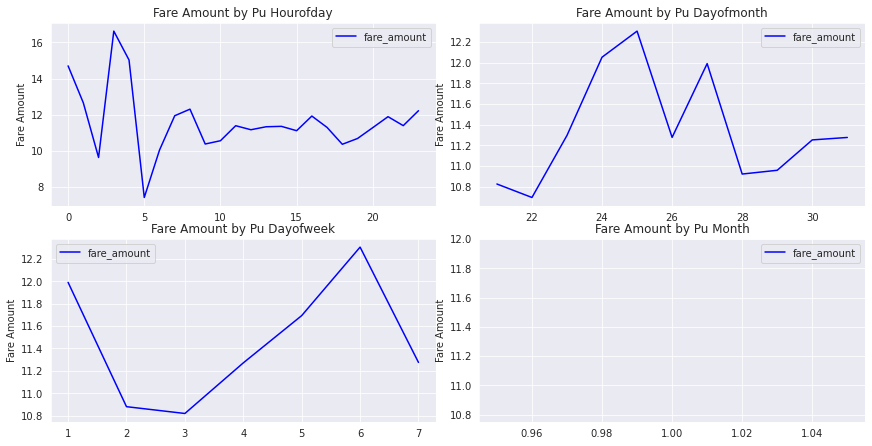

In [10]:
time_slicer(df = df_pu_fare_by_time,
            timeframes = ['PU_hourofday',
                          'PU_dayofweek',
                          'PU_dayofmonth',
                          'PU_month'],
            value = 'fare_amount',
            color="blue")

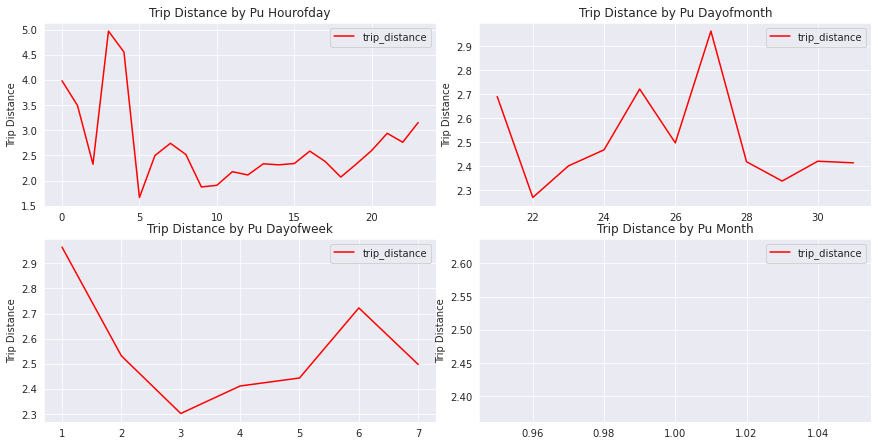

In [11]:
time_slicer(df = df_pu_fare_by_time,
            timeframes = ['PU_hourofday',
                          'PU_dayofweek',
                          'PU_dayofmonth',
                          'PU_month'],
            value = 'trip_distance',
            color="red")

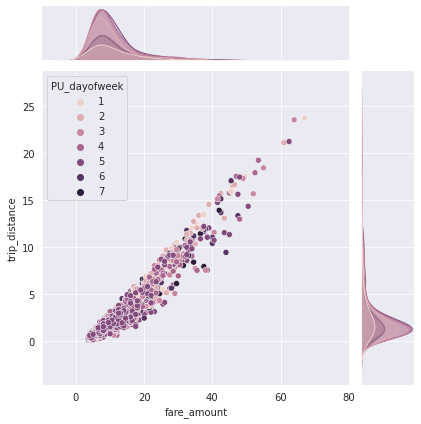

In [12]:
# more random pltos
sns.jointplot(x=df_pu_fare_by_time['fare_amount'],
              y=df_pu_fare_by_time['trip_distance'],
              hue=df_pu_fare_by_time['PU_dayofweek'])

In [13]:
spark.sql("CLEAR CACHE")
spark.stop()